In [20]:
from utils import *
from matplotlib import pyplot as plt

<>:1: SyntaxWarning: invalid escape sequence '\E'
<>:1: SyntaxWarning: invalid escape sequence '\E'
C:\Users\krzysztof\AppData\Local\Temp\ipykernel_7584\3594568446.py:1: SyntaxWarning: invalid escape sequence '\E'
  chess = video_from_path('recordings\Easy1.mp4')


Video loaded
912 720
30.00030000300003


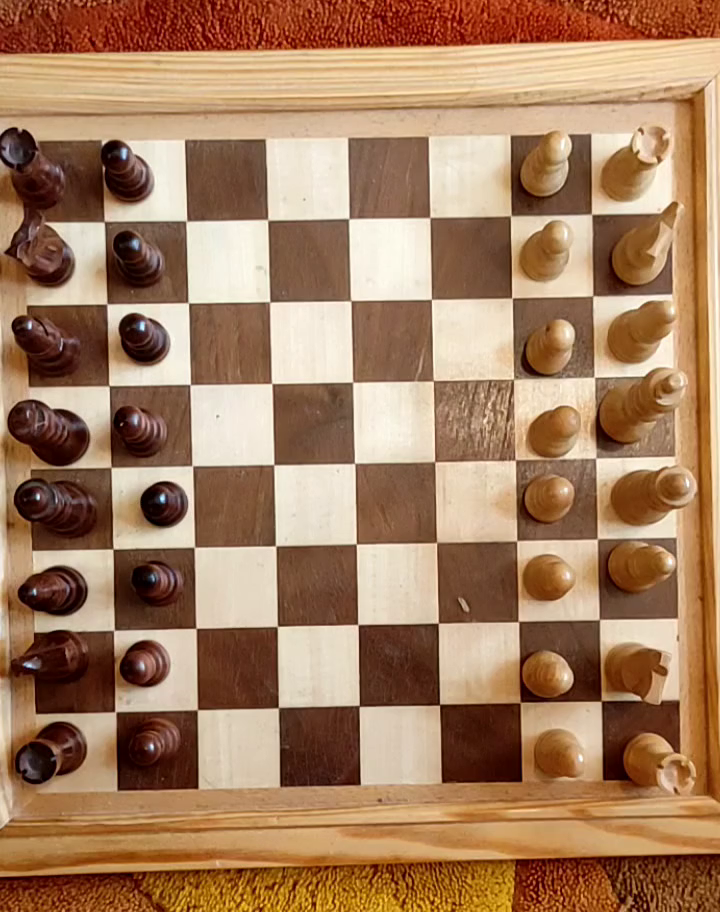

In [2]:
chess = video_from_path('recordings\Easy1.mp4')
frame = get_first_frame(chess)
contours = load_contour_parameters('Easy1')[0]

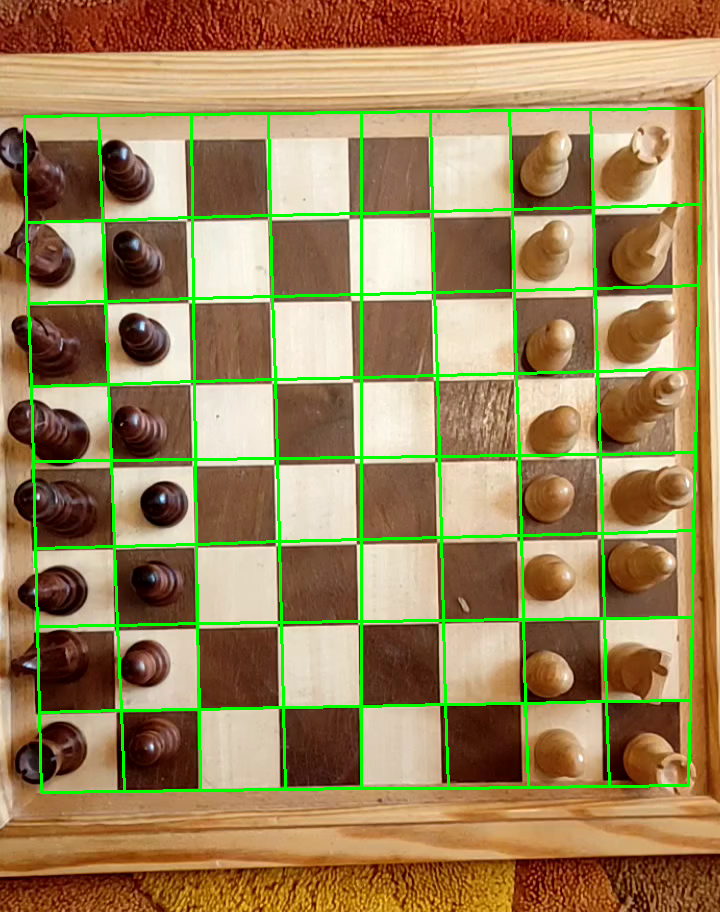

In [3]:
frame_copy = frame.copy()
cv2.drawContours(frame_copy, contours, -1, (0, 255, 0), 2)
imshow(frame_copy)

### Sobel analyses

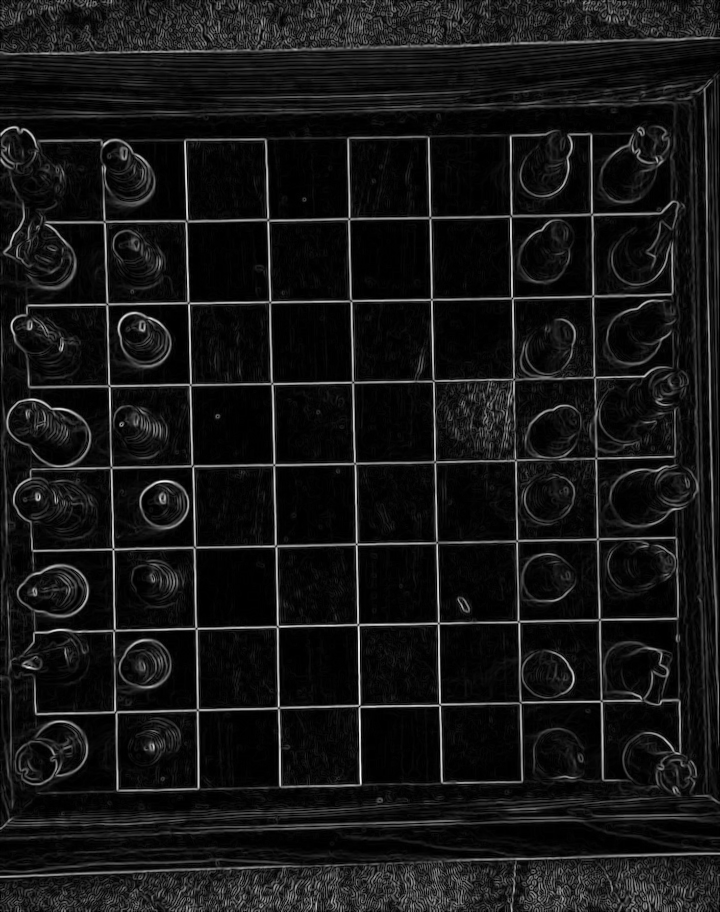

In [4]:
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

sobel_x = cv2.Sobel(gray_frame, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray_frame, cv2.CV_64F, 0, 1, ksize=3)

sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
sobel_combined = np.uint8(sobel_combined / np.max(sobel_combined) * 255)

imshow(sobel_combined)

In [11]:
def average_brightness(contour, image):
    mask = np.zeros_like(image)
    cv2.drawContours(mask, [contour], -1, 255, -1)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    nonzero_pixels = cv2.countNonZero(masked_image)
    if nonzero_pixels > 0:
        total_brightness = np.sum(masked_image) / nonzero_pixels
        return total_brightness
    return 0  # Return 0 if no pixels in the contour region

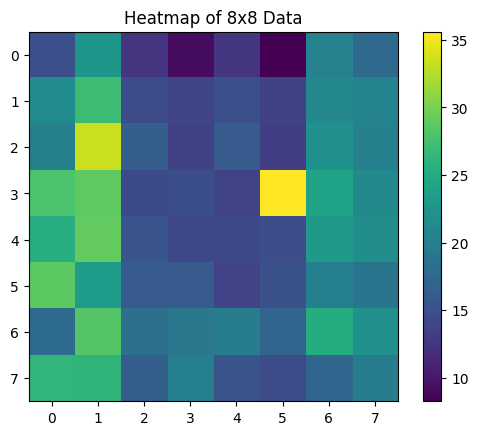

In [14]:
brightness = np.zeros(64)
for i, contour in enumerate(contours):
    brightness[i] = average_brightness(contour, sobel_combined)

brightness = brightness.reshape((8,8))

plt.imshow(brightness, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Show color bar
plt.title('Heatmap of 8x8 Data')
plt.show()

### Circle finding

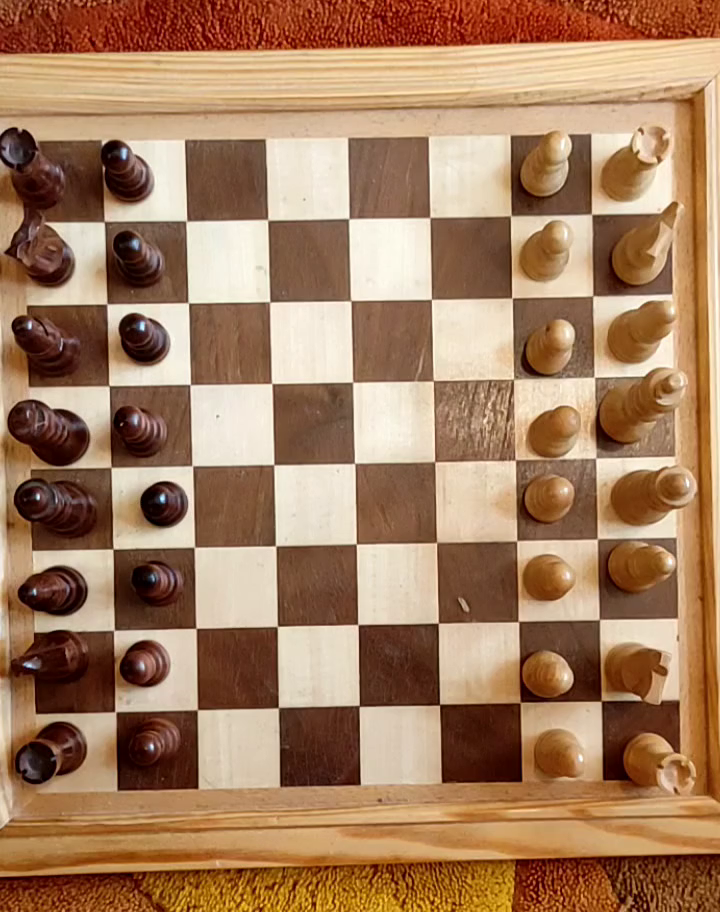

In [109]:
chess.set(cv2.CAP_PROP_POS_FRAMES, 0)
_, frame = chess.read()
imshow(frame)

[(164, 504), (34, 762), (638, 498), (58, 440), (638, 258), (146, 664), (64, 590), (636, 182), (146, 342), (638, 342), (558, 442), (542, 258), (546, 676), (648, 758), (128, 180), (546, 576), (138, 264), (266, 890), (544, 172), (630, 670), (634, 564), (50, 266), (16, 146), (38, 500), (628, 410), (550, 350), (146, 594), (554, 750), (666, 126), (546, 496), (142, 438), (160, 736), (22, 326)]


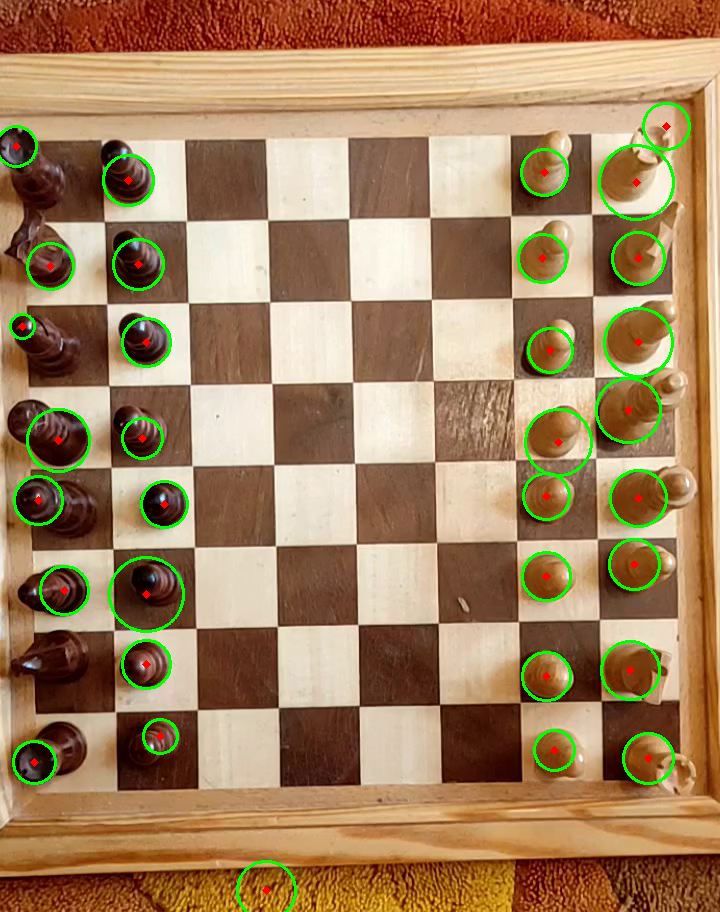

In [110]:
def find_circles(frame):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_frame, (9, 9), 2)

    circles = cv2.HoughCircles(
        blurred_image, cv2.HOUGH_GRADIENT, dp=1, minDist=50, param1=100, param2=20, minRadius=10, maxRadius=50
    )

    image = frame.copy()

    if circles is not None:
        circles = np.uint16(np.around(circles))
        centers = list()

        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]
            # Draw the outer circle
            cv2.circle(image, center, radius, (0, 255, 0), 2)
            # Draw the center of the circle
            cv2.circle(image, center, 2, (0, 0, 255), 3)

            centers.append(center)

    return image, centers

image, centers = find_circles(frame)
print(centers)
imshow(image)

### Other edge analyses 

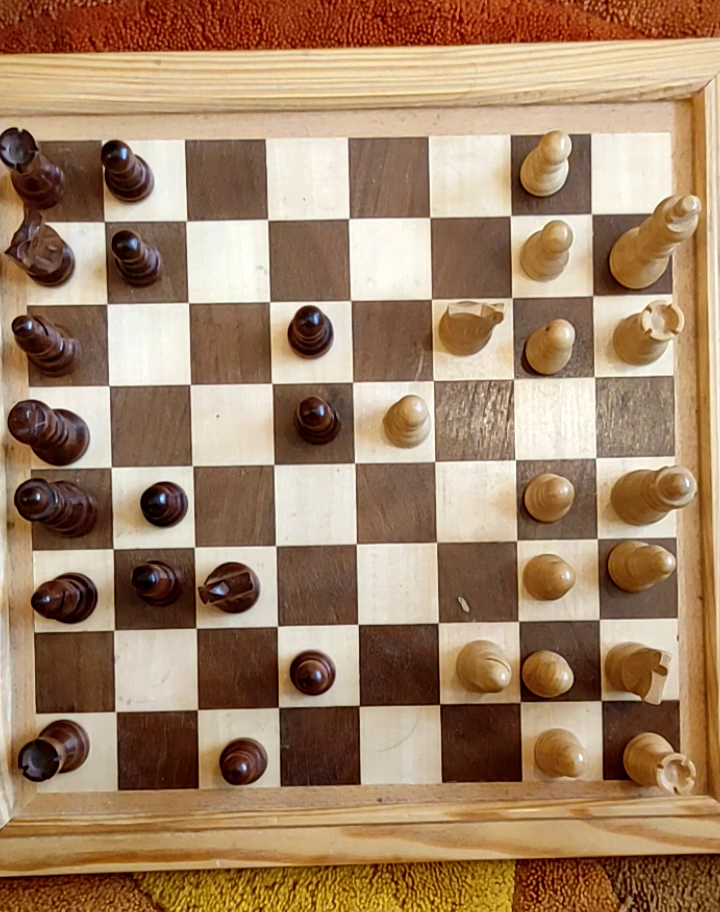

In [50]:
chess.set(cv2.CAP_PROP_POS_FRAMES, 2000)
_, frame = chess.read()
imshow(frame)

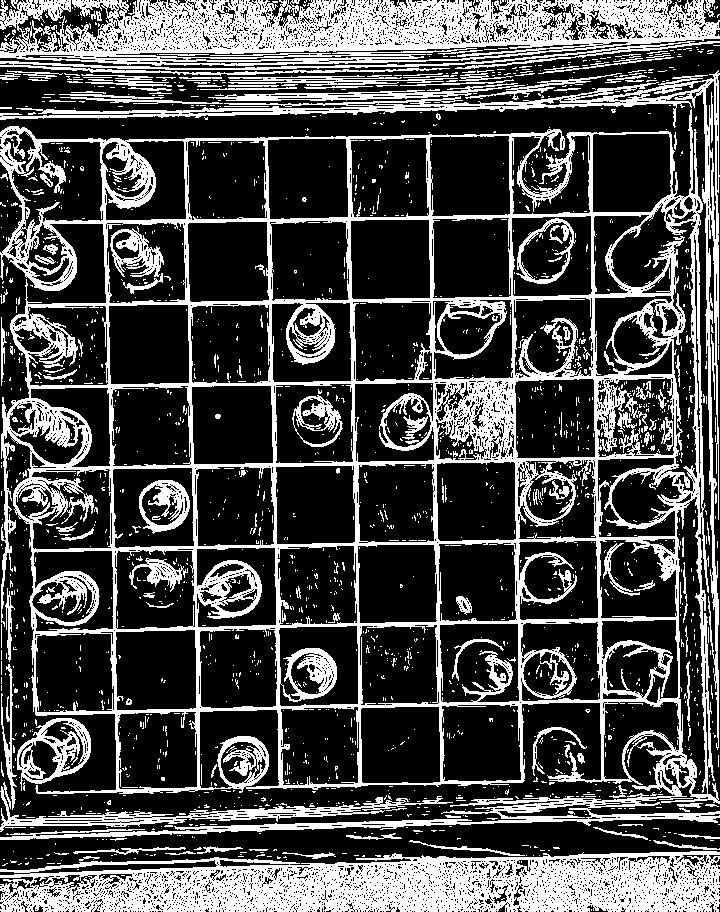

In [51]:
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

sobel_x = cv2.Sobel(gray_frame, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray_frame, cv2.CV_64F, 0, 1, ksize=3)

sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
sobel_combined = np.uint8(sobel_combined / np.max(sobel_combined) * 255)

sobel_threshold = 255 * (sobel_combined > 20).astype(np.uint32)

imshow(sobel_threshold)

In [52]:
def average_contour_distance(image, contours):
    distances = [list() for _ in range(64)]
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] > 0:
                for k , contour in enumerate(contours):
                    distance = cv2.pointPolygonTest(contour, (j, i), measureDist=True)
                    if distance > 5:
                        distances[k].append(distance * image[i][j])

    return distances

distances = average_contour_distance(sobel_threshold, contours)


In [53]:
distances_average = np.array([np.average(d) for d in distances])
distances_average = distances_average.reshape((8,8))
distances_average.shape

(8, 8)

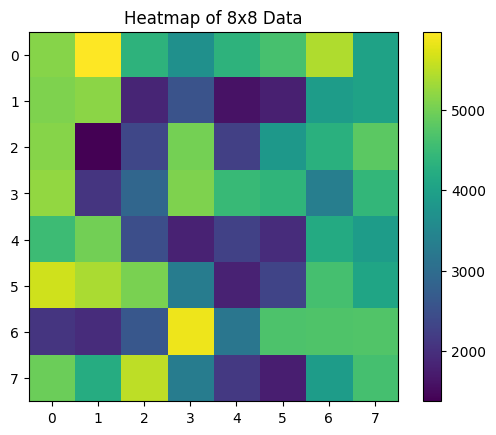

In [54]:
plt.imshow(distances_average, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Show color bar
plt.title('Heatmap of 8x8 Data')
plt.show()

### background

In [85]:
width = int(chess.get(3))
height = int(chess.get(4))

fps = chess.get(cv2.CAP_PROP_FPS)

background_writer = cv2.VideoWriter(
    "test/test1.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (width, height),
    0,
)

foreground_mog2 = cv2.createBackgroundSubtractorMOG2()


chess.set(cv2.CAP_PROP_POS_FRAMES, 0)
while chess.isOpened():
    ret, frame = chess.read()

    if ret:
        background_writer.write(foreground_mog2.apply(frame))
    else:
        break

background_writer.release()

In [64]:
foreground_video = video_from_path('test/test1.mp4')

Video loaded
912 720
30.0


In [75]:
width = int(foreground_video.get(3))
height = int(foreground_video.get(4))

fps = foreground_video.get(cv2.CAP_PROP_FPS)

average_foregrounds = list()

foreground_video.set(cv2.CAP_PROP_POS_FRAMES, 0)
while foreground_video.isOpened():
    ret, frame = foreground_video.read()

    if ret:
        average_foregrounds.append(np.average(frame))
    else: 
        break

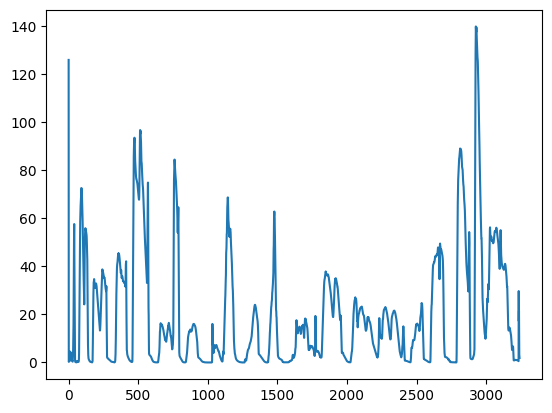

In [76]:
plt.plot(average_foregrounds)

In [91]:
width = int(chess.get(3))
height = int(chess.get(4))

fps = chess.get(cv2.CAP_PROP_FPS)

test_writer = cv2.VideoWriter(
    "test/test2.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (width, height),
    1,
)

i = 0
used_frames = np.zeros(len(average_foregrounds), np.bool_)

chess.set(cv2.CAP_PROP_POS_FRAMES, 0)
while chess.isOpened():
    ret, frame = chess.read()
    if ret:
        if average_foregrounds[i] < 10:
            test_writer.write(frame)
            used_frames[i] = True
        i += 1
    else:
        break

test_writer.release()

### circle on the video

In [100]:
hand_cut = video_from_path('test/test2.mp4')

width = int(hand_cut.get(3))
height = int(hand_cut.get(4))

fps = hand_cut.get(cv2.CAP_PROP_FPS)


test_writer3 = cv2.VideoWriter(
    'test/test3_circles.mp4',
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (width, height),
    True
)

centers_frame = list()

hand_cut.set(cv2.CAP_PROP_POS_FRAMES, 0)
while hand_cut.isOpened():
    ret, frame = hand_cut.read()

    if ret:
        image, centers = find_circles(frame)
        centers_frame.append(centers)
        test_writer3.write(image)
    else:
        break

test_writer3.release()

Video loaded
912 720
30.0


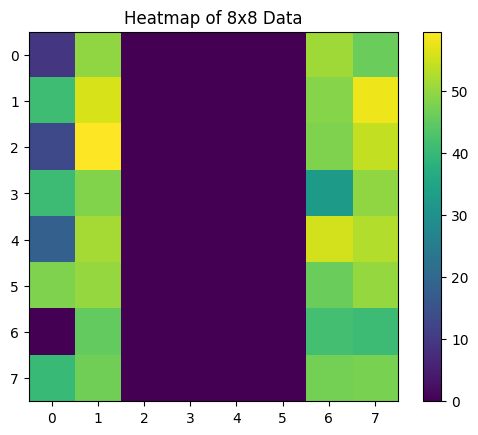

In [112]:
contours_frame = load_contour_parameters('Easy1')

circles_count = np.zeros(64)

j = 0
for i, contour in enumerate(contours):
    for center in centers_frame[j]:
        distance = cv2.pointPolygonTest(contour, center, measureDist=True)
        bias = 20
        if distance > -bias:
            circles_count[i] += distance + bias


plt.imshow(circles_count.reshape((8, 8)), cmap='viridis', interpolation='nearest')
plt.colorbar()  # Show color bar
plt.title('Heatmap of 8x8 Data')
plt.show()



In [114]:
contours_frame = load_contour_parameters('Easy1')

n = np.sum(used_frames)
circles_count = np.zeros((n, 64))

j = 0
for k, contours in enumerate(contours_frame):
    if used_frames[k]:
        for i, contour in enumerate(contours):
            for center in centers_frame[j]:
                distance = cv2.pointPolygonTest(contour, center, measureDist=True)
                bias = 20
                if distance > -bias:
                    circles_count[j][i] += distance + bias
        j += 1


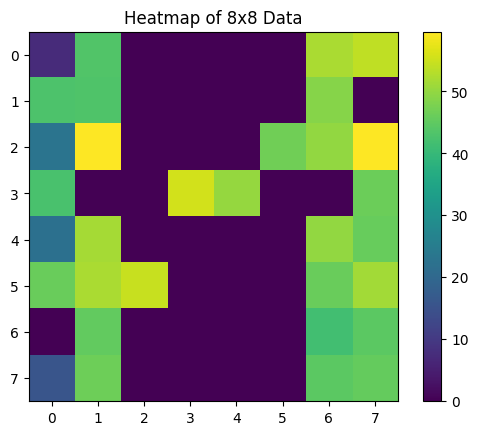

In [123]:
plt.imshow(circles_count[300].reshape((8,8)), cmap='viridis', interpolation='nearest')
plt.colorbar()  # Show color bar
plt.title('Heatmap of 8x8 Data')
plt.show()